In [4]:
%load_ext autoreload
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import select_rows, sparsity_aware_dist, polis_umap, polis_pca
# from utils.community_detection import polis_community_detection
# from utils.subconversation import comment_visualization, polis_subconversation
# import leidenalg
# from collections import Counter
# from utils.community_detection import show_embedding
# from utils.graph_generation import generate_kneighbors_graph, generate_pos_neg_graphs, generate_dual_graph
# from utils.graph_clustering import polis_leiden_onelayer, polis_leiden_twolayers

# from utils.community_detection import polis_leiden_onelayer

from utils.community_detection import polis_subconversation_kNN_graph, polis_subconversation_Adjacency_matrix,polis_subconversation_Adjacency_matrix_two_layers

# Visualization parameters
plt.figure(figsize=(500, 500));
sns.set_context('poster');
sns.set_style('white');
sns.set(font_scale=.7);
sns.set_color_codes();
np.seterr(divide='ignore', invalid='ignore');

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 36000x36000 with 0 Axes>

# Import data

In [5]:
# Import participants votes
df = pd.read_csv('Data/american-assembly.bowling-green/participants-votes.csv',index_col='participant')
df.head(3)

,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,4,...,886,887,888,889,890,891,892,893,894,895
participant,,,,,,,,,,,,,,,,,,,,,
0,0.0,92,610,397,100,-1.0,-1.0,1.0,1.0,1.0,...,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0
2,0.0,0,29,23,6,-1.0,1.0,1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0,29,20,6,-1.0,1.0,1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Import participants' comments
df_comments = pd.read_csv('Data/american-assembly.bowling-green/comments.csv',index_col='comment-id')
df_comments.index = df_comments.index.astype(str)
df_comments.head(3)

,timestamp,datetime,author-id,agrees,disagrees,moderated,comment-body
comment-id,,,,,,,
895,1518501496471,Tue Feb 13 12:58:16 WIB 2018,1756,48,8,1,Smallhouse Rd (at Campbell Ln) heading into to...
894,1518499107516,Tue Feb 13 12:18:27 WIB 2018,1480,27,16,1,Doctors should not overreact to the opioid cri...
893,1518498500733,Tue Feb 13 12:08:20 WIB 2018,1751,33,18,1,More free meeting space for nonprofits.


In [7]:
# Set Metadata fields and variable fields
metadata_fields = ['group-id', 'n-comments', 'n-votes', 'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

# remove statements (columns) which were moderated out
# df_comments["moderated"] = 0   --->   comment should be removed
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

# Remove participants with less than N (threshold) votes.
df = select_rows(df=df, val_fields=val_fields, threshold=60)

# Preprocess
metadata = df[metadata_fields]
vals = df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")

## Overall statistics

In [8]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (1006, 901)
Dimensions of matrix: (1006, 896)
Total number of possible votes: 901376
Total number of agrees: 100041
Total number of disagrees: 35177
Total without vote: 766158
Percent sparse:  0.8499871307867083 %


## Comment selection

In [9]:
vals_all_in = vals[statements_all_in]

# Comparison of k-neighbor and two-layer graph approaches

* Currently a k-neighbor graph of the participant-votes matrix is given as input to the Leiden algorithm for community detection.
* However, the participant-votes matrix can be given directly.
* Quality of results is low, if the adjacency matrix is given as-is, in one-layer format.
    * That is, as a weighted adjacency matrix with 1.0 for positive links, and -1.0 for negative ones.
* Quality of results is comparable to k-neighbors graph, if the two-layer structure is explicitly given as input to the Leiden algorithm.
    * That is, the weighted adjacency matrix is split in two, G_pos and G_neg.
    * G_pos is an unweighted version of the same matrix, with 1.0 where positive links exists and 0.0 otherwise.
    * G_neg is defined similarly for the negative links.
    * Both layers are given as input to Leiden, with layer_weights=[1 -1] 
    * (i.e. preferring positive connections and penalizing negative ones.)

# Sub-conversation kNN graph

[INFO] Application of PCA: Complete
Explained variance: [0.34203885 0.16328063]
[INFO] Application of UMAP: Complete
[INFO] Community detection (K-neighbors, one layer, modularity): Dataframe shape: (100, 10)
Kneighbor graph shape: (100, 100)
Complete
[INFO] Number of communities detected: 8
[INFO] Sequence of communities detected: Counter({0: 17, 1: 14, 2: 14, 3: 13, 4: 11, 6: 11, 5: 11, 7: 9})


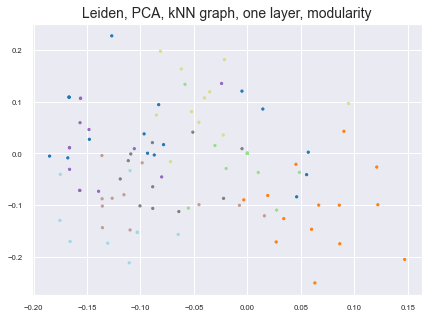

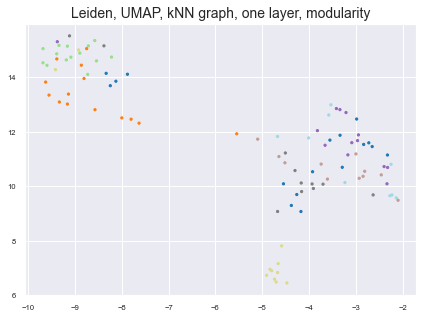

In [14]:
leidenClusters, coords, embedding = polis_subconversation_kNN_graph(vals_all_in.iloc[:100,:10])

In [11]:
# ADDRESS ERROR

# from utils.utils import comment_visualization

# comments_ids = ['4', '5']

# # Opinion of select community about specific comments
# for x in comments_ids:
#     comment = df_comments['comment-body'][x]
#     comment_visualization(dataframe=vals_all_in, comment_id=x, comment=comment, coords=coords, embedding=embedding)

# Sub-conversation Adjacency matrix, one layer

[INFO] Application of PCA: Complete
Explained variance: [0.34203885 0.16328063]
[INFO] Application of UMAP: Complete
[INFO] Community detection (Adjacency matrix, one layer, modularity): Nr of communities detected: 10
Seq of communities detected: Counter({0: 42, 1: 35, 2: 16, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1})


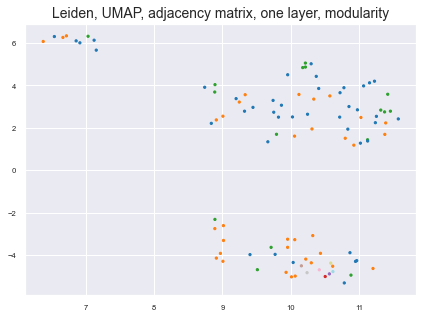

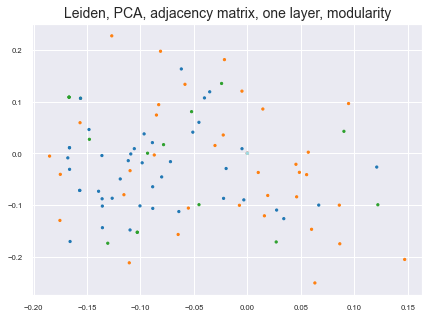

In [12]:
leidenClusters, coords, embedding = polis_subconversation_Adjacency_matrix(vals_all_in.iloc[:100,:10])

# Sub-conversation Adjacency matrix, two layers

[INFO] Application of PCA: Complete
Explained variance: [0.34203885 0.16328063]
[INFO] Application of UMAP: Complete
[INFO] Community detection (Adjacency matrix, two layers, modularity): Nr of communities detected: 11
Seq of communities detected: Counter({0: 36, 1: 29, 2: 27, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1})


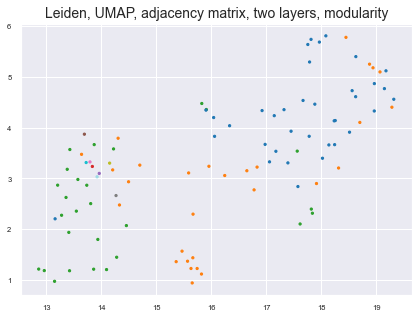

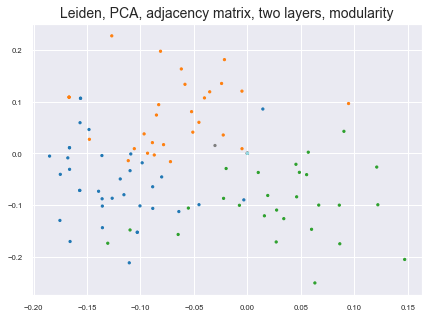

[INFO] Community detection (Adjacency matrix, two layers, CPM): Nr of communities detected: 16
Seq of communities detected: Counter({0: 58, 1: 13, 2: 11, 3: 6, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 15: 1, 14: 1, 13: 1})


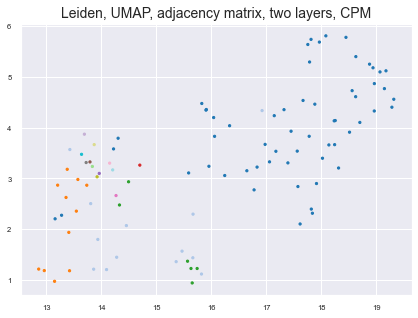

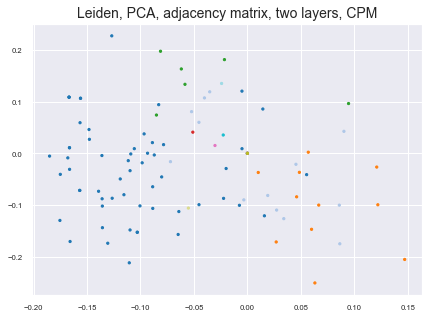

In [13]:
leidenClusters, coords, embedding = polis_subconversation_Adjacency_matrix_two_layers(vals_all_in.iloc[:100,:10])